In [1]:
import openslide
import math
import sys, os
import cv2
import tables
import random

import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk # (modified with elastix)
import pandas as pd
import seaborn as sns


from collections import Counter 
from skimage.transform import resize
from tifffile import imread, imwrite
from ipywidgets import interact, fixed
from skimage import morphology, filters
import sklearn.feature_extraction.image
from PIL import Image

from sklearn.model_selection import train_test_split

from misc.utils import *

import torch
import logging

import glob
import traceback
import json

from pathlib import Path
from tqdm.autonotebook import tqdm
from scipy.spatial.distance import cdist



# Global Variables

In [2]:
# Path of IF and HE image files 

IF_path = 'Experiment/IF40X/HE2mIF_MELANOME_3/Scan1/HE2mIF_MELANOME_3_Scan1.qptiff'
HE_path = 'Experiment/HE40X/MELANOMA_AA3_40X/Scan1/MELANOMA_AA3_40X_Scan1.qptiff'


# Retrieve Cells

## Cells Locations

In [3]:
# Load images using OpenSlide
IF_open = openslide.OpenSlide(IF_path)
HE_open = openslide.OpenSlide(HE_path)

# Gets the origin of the IF image
# cm to micrometer to find this it will find 
OR_x = float(IF_open.properties['tiff.XPosition'])*10000
OR_y = float(IF_open.properties['tiff.YPosition'])*10000

# Gets the resolution of the IF image
x_resolution = float(IF_open.properties['tiff.XResolution'])*1e-4
y_resolution = float(IF_open.properties['tiff.YResolution'])*1e-4


dimensions = IF_open.dimensions

In [4]:
# Reads the cell locations from inForm analysis software
cells_locations = pd.read_csv('Experiment/Cells_locations/Melanome_3/Merged__cell_seg_data.txt', sep='\t', usecols=['Cell X Position', 'Cell Y Position', 'Phenotype'])

# Removes the offset (origin)
cells_locations['cell_x_position'] = cells_locations['Cell X Position'] - OR_x
cells_locations['cell_y_position'] = cells_locations['Cell Y Position'] - OR_y

# Converts the position from cm to pixel position
cells_locations['cell_xpixel_position'] = cells_locations.cell_x_position.apply(lambda x: x*x_resolution).values
cells_locations['cell_ypixel_position'] = cells_locations.cell_y_position.apply(lambda x: x*y_resolution).values

In [5]:
#cells_locations

## Mask Generation

['CD3p', 'SOX10p', 'CD56p', 'CD11Cp', 'CD68p', 'CD20p']

In [6]:
# Creates an empty image of the size of the original IF image
dots = sitk.Image(dimensions[0], dimensions[1], sitk.sitkUInt8)

phenotype = 'CD3p'

for x,y in zip(cells_locations[cells_locations['Phenotype']==phenotype].cell_xpixel_position.values, cells_locations[cells_locations['Phenotype']==phenotype].cell_ypixel_position.values):
    
    
    # Draws points at cell locations of the empty image for a specific phenotype
    draw_point(dots, x=int(x), y=int(y), size=3)

    


# mIF to H&E Image Registration 

## Load Image & ROI Selection

In [11]:
# Choose ROI size (Better to take a square)
size=(2000,2000)

# Manually select the corresponding origin of both image
IF_origin = (9270,37150)
HE_origin = (12000,38000)


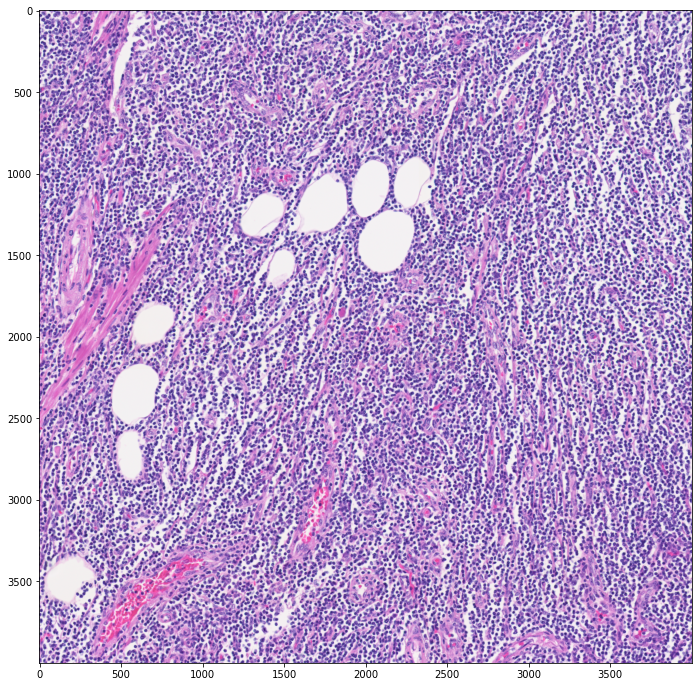

In [12]:

HE_open_visu = openslide.OpenSlide(HE_path)
HE_open_visu = np.asarray(HE_open_visu.read_region(HE_origin,0,size)).copy()

fig, ax = plt.subplots(1,1,figsize=(12,12))
ax.imshow(HE_open_visu[0:size[0],0:size[1]])
#IF_open_visu = openslide.OpenSlide(IF_path)
#IF_open_visu = np.asarray(IF_open_visu.read_region(IF_origin,0,size)).copy()

#fig, ax = plt.subplots(1,1,figsize=(12,12))
#ax.imshow(IF_open_visu[0:size[0],0:size[1]])


# Hovernet Segmentation 

Here we will run the segmentation using the Hovernet Model on the ROI.
Using the locations produced by the Hovernet Segmentation we will locate the different cells and obtain the phentoype using the registered IF image.

In [10]:
# +
patch_size = 2000
outdir = "./tiles"
fnamebase = "Melanoma"
rm_n_mkdir(f"{outdir}")

osh  = openslide.OpenSlide(HE_path)
nrow = (int) (size[0] / patch_size)
ncol = (int) (size[1]/ patch_size)

for y in tqdm(range(0,ncol), desc="outer" , leave=False):
    for x in tqdm(range(0,nrow), desc=f"inner {y}", leave=False):


        patch  = np.asarray(osh.read_region((HE_origin[0]+ patch_size * x, HE_origin[1] + patch_size * y), 0, (patch_size,patch_size)))[:,:,0:3] #trim alpha


        patch=cv2.cvtColor(patch,cv2.COLOR_RGB2BGR)
        cv2.imwrite(f"{outdir}/{fnamebase}_{HE_origin[0]}_{HE_origin[1]}_{x}_{y}.png", patch)

osh.close()


print(f"Done making patches!")


outer:   0%|          | 0/1 [00:00<?, ?it/s]

inner 0:   0%|          | 0/1 [00:00<?, ?it/s]

Done making patches!


In [11]:
# Checking for GPU
gpu_list = '0'
os.environ['CUDA_VISIBLE_DEVICES'] = gpu_list
nr_gpus = torch.cuda.device_count()
print('Detect #GPUS: %d' % nr_gpus)


Detect #GPUS: 1


In [12]:
method_args = {
    'method' : {
        'model_args' : {
            'nr_types'   : None,
            'mode'       : 'original',
        },
        'model_path' : 'pretrained/hovernet_original_consep_notype_tf2pytorch.tar',
    },
    'type_info_path'  : None,
}
run_args = {
    'batch_size' : 8 * nr_gpus,
    'nr_inference_workers' : 8,
    'nr_post_proc_workers' : 16,
    'patch_input_shape': 270,
    'patch_output_shape' : 80,
    'input_dir'      : './tiles/',
    'output_dir'     : './hovernet_output/',
    'mem_usage': 0.8,
    'draw_dot' : False,
    'save_qupath' : False,
    'save_raw_map' : False,
}

In [13]:
from infer.tile import InferManager
infer = InferManager(**method_args)
infer.process_file_list(run_args)


Process Patches: 100%|##########################| 79/79 [00:28<00:00,  2.79it/s]


In [14]:
fnamebase = "Melanoma"
nrow = (int) (size[0] / patch_size)
ncol = (int) (size[1]/ patch_size)

HE_cells_locations = pd.DataFrame(columns=['point'])
for y in tqdm(range(0,ncol), desc="outer" , leave=False):
    for x in tqdm(range(0,nrow), desc=f"innter {y}", leave=False):
        f = open(f"./hovernet_output/json/{fnamebase}_{HE_origin[0]}_{HE_origin[1]}_{x}_{y}.json",)

        data = json.load(f)
        # print(data)
        for index in data['nuc']:
            HE_cells_locations = HE_cells_locations.append({'point': (data['nuc'][index]['centroid'][0]+ patch_size * x,data['nuc'][index]['centroid'][1]+ patch_size * y)}, ignore_index=True)
        f.close()


outer:   0%|          | 0/1 [00:00<?, ?it/s]

innter 0:   0%|          | 0/1 [00:00<?, ?it/s]

In [15]:
# Read region at the specified origin with the specified size
IF_open = np.asarray(IF_open.read_region(IF_origin, 0, size))[:,:,0]

In [16]:
HE_open = np.asarray(HE_open.read_region(HE_origin, 0, size))[:,:,0]

In [17]:
IF_open.shape

(2000, 2000)

In [18]:
dots.GetSize()

(55680, 93600)

In [19]:
# Crops the dots image exactly like the IF image

dots = dots[IF_origin[0]:IF_origin[0]+size[0],IF_origin[1]:IF_origin[1]+size[1]]
dots.SetOrigin((0,0))

In [20]:
dots.GetSize()

(2000, 2000)

In [21]:
# Converts the image to ITK format

IF_open = sitk.GetImageFromArray(IF_open)
HE_open = sitk.GetImageFromArray(HE_open)

## Image Pre-Registration (Elastix)

In [22]:
# Downscale the images
HE_resize_ITK, IF_resize_ITK, x_scaling_factor_IF, y_scaling_factor_IF  = downscale_pair_image(sitk.GetArrayFromImage(HE_open),sitk.GetArrayFromImage(IF_open))

# initialize the registration
elastixImageFilter = sitk.ElastixImageFilter()

# sets the fixed image
elastixImageFilter.SetFixedImage(sitk.Normalize(HE_resize_ITK))

# set the moving image
elastixImageFilter.SetMovingImage(sitk.Normalize(IF_resize_ITK))

parameterMapVector = sitk.VectorOfParameterMap()

# add translation and affine transforms to the paramter map
parameterMapVector.append(sitk.GetDefaultParameterMap("translation"))
parameterMapVector.append(sitk.GetDefaultParameterMap("affine")) # --> rigid to try 

elastixImageFilter.SetParameterMap(parameterMapVector)

print(bcolors.OKBLUE + "Registering resized image" + bcolors.ENDC)
elastixImageFilter.Execute()
print(bcolors.OKGREEN + "done" + bcolors.ENDC)

Registering resized image
done


In [ ]:
print("Rescaling original IF Image")

# gets the downscaled parameter map that needs to be rescaled
parameterMap = elastixImageFilter.GetTransformParameterMap()

# gets translation parameters
transform_parameters_translation = parameterMap[0]["TransformParameters"]
size_parameters = parameterMap[0]["Size"]

# gets affine parameters (affine)
transform_parameters_rotation = parameterMap[1]["CenterOfRotationPoint"]

# rescaling the parameters
rescaled_parameters_translation = (str(float(transform_parameters_translation[0])*y_scaling_factor_IF), str(float(transform_parameters_translation[1])*x_scaling_factor_IF))
rescaled_size = (str(int(float(size_parameters[0])*y_scaling_factor_IF)), str((int(float(size_parameters[1])*x_scaling_factor_IF))))

rescaled_parameters_rotation = (str(float(transform_parameters_rotation[0])*y_scaling_factor_IF), str(float(transform_parameters_rotation[1])*x_scaling_factor_IF))

# sets the new parameters
parameterMap[0]["TransformParameters"] = rescaled_parameters_translation
parameterMap[0]["Size"] = rescaled_size

parameterMap[1]["CenterOfRotationPoint"] = rescaled_parameters_rotation
parameterMap[1]["Size"] = rescaled_size

transformix = sitk.TransformixImageFilter()

# sets the new rescaled parameters 
transformix.SetTransformParameterMap(parameterMap)

# transforming the original IF image (pre-registration)
transformix.SetMovingImage(IF_open)
transformix.Execute()

IF_open = transformix.GetResultImage()

In [ ]:
# Applying the same pre-registration to the dots

print("Rescaling original dots Image")

transformix.SetMovingImage(dots)
transformix.Execute()

dots = transformix.GetResultImage()


## WSI Registration 

In [ ]:
tile_size_x = 2000
tile_size_y = 2000

# creating pairs of 2000 x 2000 pixel tiles



IF_open = tiling(IF_open, tile_size_x, tile_size_y)
#tiling(HE_open, tile_size_x, tile_size_y,True)
HE_open = tiling(sitk.Cast(HE_open,sitk.sitkFloat32), tile_size_x, tile_size_y)


In [ ]:
# tiling the dot image the same way
dots = tiling(dots, tile_size_x, tile_size_y)

In [ ]:
#index = 0
#interact(display_images_with_alpha, alpha=(0,1,0.2), fixed = fixed(sitk.Cast(HE_open[index],sitk.sitkFloat32)), moving = fixed(sitk.Cast(IF_open[index],sitk.sitkFloat32)))

In [ ]:
# Set regis to True if you want the registered images. 
param = translate_arrays(HE_open, IF_open, method = ['rigid', 'affine', 'bspline'], weight = 500, regis = False, num_iter=500, number_resolution = 5)

In [ ]:
#interact(display_images_with_alpha, alpha=(0,1,0.2), fixed = fixed(sitk.Cast(HE_open[index],sitk.sitkFloat32)), moving = fixed(sitk.Cast(regis[index],sitk.sitkFloat32)))

In [ ]:
# transform the dots positions with the saved parameters
dots_registered = transform_array(dots, param)


In [ ]:
#interact(display_images_with_alpha, alpha=(0,1,0.2), fixed = fixed(sitk.Cast(HE_open[index],sitk.sitkFloat32)), moving = fixed(sitk.Cast(dots_registered[index],sitk.sitkFloat32)))

In [ ]:
# reconstruct back the image
dots_registered = reconstruct_image(size=size, frames=dots_registered)


In [ ]:
dots_registered.shape

## Transforming new positions

In [ ]:
# Get array format to apply image processing techniques
dots_registered = sitk.GetArrayFromImage(sitk.Cast(sitk.GetImageFromArray(dots_registered),sitk.sitkUInt8))


# Retrieving new cell positions

## Dots Filtering to single pixel

In [ ]:
# sets a morphological shape (disk of radius 4)
selem = morphology.disk(4)
res=filters.median(dots_registered,selem)

# sets a morphological shape (disk of radius 2)
selem = morphology.disk(2)
res=morphology.dilation(res, selem)

# sets a morphological shape (disk of radius 2)
selem = morphology.disk(2)
res=morphology.opening(res, selem)


In [ ]:
# Creates an empty pandas dataframe
dots_cells_locations = pd.DataFrame(columns=['point', 'type'])
dots_cells_locations.head()

In [ ]:
# Binaries the image
ret, thresh = cv2.threshold(res,5,255,0)

# Gets the contours (shapes)
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Extract positions
for index, c in enumerate(contours): 
    M = cv2.moments(c)
    
    x = int(M["m10"]/M["m00"]) + 0
    y = int(M["m01"]/M["m00"]) + 0
    
    dots_cells_locations = dots_cells_locations.append({'point': (x,y), 'type':phenotype}, ignore_index=True)
    
del dots, res, thresh

In [ ]:
dots_cells_locations

# Other cell types
['SOX10p', 'CD56p', 'CD11Cp', 'CD68p', 'CD20p', 'DAPIp']

In [ ]:
# Creates an empty image of the size of the original IF image
phenotypes = ['SOX10p', 'CD56p', 'CD11Cp', 'CD68p', 'CD20p','DAPIp']
for phenotype in phenotypes :
    print(phenotype)
    dots = sitk.Image(dimensions[0], dimensions[1], sitk.sitkUInt8)


    for x,y in zip(cells_locations[cells_locations['Phenotype']==phenotype].cell_xpixel_position.values, cells_locations[cells_locations['Phenotype']==phenotype].cell_ypixel_position.values):
        
        
        # Draws points at cell locations of the empty image for a specific phenotype
        
        draw_point(dots, x=int(x), y=int(y), size=3)

    # Crops the dots image exactly like the IF image

    dots = dots[IF_origin[0]:IF_origin[0]+size[0],IF_origin[1]:IF_origin[1]+size[1]]
    dots.SetOrigin((0,0))

    # Applying the same pre-registration to the dots

    print("Rescaling original dots Image")

    transformix.SetMovingImage(dots)
    transformix.Execute()

    dots = transformix.GetResultImage()

    # tiling the dot image the same way
    dots = tiling(dots, tile_size_x, tile_size_y)

    # transform the dots positions with the saved parameters
    dots_registered = transform_array(dots, param)

    # reconstruct back the image
    dots_registered = reconstruct_image(size=size, frames=dots_registered)

    # Get array format to apply image processing techniques
    dots_registered = sitk.GetArrayFromImage(sitk.Cast(sitk.GetImageFromArray(dots_registered),sitk.sitkUInt8))

    # sets a morphological shape (disk of radius 4)
    selem = morphology.disk(4)
    res=filters.median(dots_registered,selem)

    # sets a morphological shape (disk of radius 2)
    selem = morphology.disk(2)
    res=morphology.dilation(res, selem)

    # sets a morphological shape (disk of radius 2)
    selem = morphology.disk(2)
    res=morphology.opening(res, selem)

    # Binaries the image
    ret, thresh = cv2.threshold(res,5,255,0)

    # Gets the contours (shapes)
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Extract positions
    for index, c in enumerate(contours): 
        M = cv2.moments(c)
        
        x = int(M["m10"]/M["m00"]) + 0
        y = int(M["m01"]/M["m00"]) + 0
        
        dots_cells_locations = dots_cells_locations.append({'point':(x,y), 'type':phenotype}, ignore_index=True)
        
    del dots, res, thresh




In [ ]:
def distance (x1,y1,x2,y2) :
    Distance = math.sqrt((x1-x2)**2 + (y1-y2)**2)
    return Distance

In [ ]:
def closest_point(point, points):
    """ Find closest point from a list of points. """
    return points[torch.cdist(torch.tensor([point]), torch.tensor(points)).argmin()]

def match_value(df, col1, x, col2):
    """ Match value x from col1 row to value in col2. """
    return df[df[col1] == x][col2].values[0]

In [ ]:
#HE_cells_locations_types = pd.DataFrame(columns=['point','type'])
#dots_cells_locations['point'] = [(float(x), float(y)) for x,y in zip(dots_cells_locations['x_coordinate'], dots_cells_locations['y_coordinate'])]
#HE_cells_locations['point'] = [(float(x), float(y)) for x,y in zip(HE_cells_locations['x_coordinate'], HE_cells_locations['y_coordinate'])]
HE_cells_locations['closest'] = [closest_point(x, list(dots_cells_locations['point'])) for x in tqdm(HE_cells_locations['point'])]
HE_cells_locations['type'] = [match_value(dots_cells_locations, 'point', x, 'type') for x in tqdm(HE_cells_locations['closest'])]

In [ ]:
Final_Registration_Output = pd.DataFrame(columns=['x_coordinate','y_coordinate','type'])
for i, HE_row in tqdm(HE_cells_locations.iterrows(),total = HE_cells_locations['point'].size()):
    if distance(HE_row['point'][0], HE_row['point'][1], HE_row['closest'][0], HE_row['closest'][1]) < 20.0 :
        Final_Registration_Output = Final_Registration_Output.append({'x_coordinate': HE_row['x_coordinate'],'y_coordinate': HE_row['y_coordinate'],'type':HE_row['type']}, ignore_index=True)


In [ ]:
Final_Registration_Output.head()

In [ ]:
Final_Registration_Output.to_csv(f'./locations/3_MEL3_HE_cells_locations_withoffset_1_{size}_{HE_origin[0]}_{HE_origin[1]}.txt', header=None, index = None, sep='\t', mode='a')
Final_Registration_Output['x_coordinate'] = Final_Registration_Output['x_coordinate'] + HE_origin[0]
Final_Registration_Output['y_coordinate'] = Final_Registration_Output['y_coordinate'] + HE_origin[1] 
Final_Registration_Output.to_csv(f'./locations/3_MEL3_HE_cells_locations_NoOffset_1_{size}_{HE_origin[0]}_{HE_origin[1]}.txt', header=None, index = None, sep='\t', mode='a')

# Visualization 

In [ ]:
df_test = Final_Registration_Output.copy()
df_test.groupby(by='type').count()

In [ ]:
df_test['x_coordinate'] = df_test['x_coordinate'] - HE_origin[0]
df_test['y_coordinate'] = df_test['y_coordinate'] - HE_origin[1] 

In [ ]:
def rgba2rgb( rgba, background=(255,255,255) ):
    row, col, ch = rgba.shape

    if ch == 3:
        return rgba

    assert ch == 4, 'RGBA image has 4 channels.'

    rgb = np.zeros( (row, col, 3), dtype='float32' )
    r, g, b, a = rgba[:,:,0], rgba[:,:,1], rgba[:,:,2], rgba[:,:,3]

    a = np.asarray( a, dtype='float32' ) / 255.0

    R, G, B = background

    rgb[:,:,0] = r * a + (1.0 - a) * R
    rgb[:,:,1] = g * a + (1.0 - a) * G
    rgb[:,:,2] = b * a + (1.0 - a) * B

    return np.asarray( rgb, dtype='uint8' )

In [ ]:
HE_open_visu = openslide.OpenSlide(HE_path)

In [ ]:
HE_open_visu = rgba2rgb(np.asarray(HE_open_visu.read_region(HE_origin,0,size)).copy())
HE_open_visu.setflags(write=1)

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(12,12))
ax.imshow(HE_open_visu[0:2000,0:2000])

In [ ]:
# BGR 
# CDC3p Red
red = (255,0,0)
# SOX10p Green 
green = (0,255,0)
# CD11Cp Blue
blue = (0,0,255)
# CD20p black
black = (0,0,0)
# CD68p White
white = (255,255,255)
# CD56p Yellow
yellow = (255,255,0)
thick = 1
rad = 15

    
for x,y in zip(df_test[df_test['type']=='CD3p'].x_coordinate.values , df_test[df_test['type']=='CD3p'].y_coordinate.values):
    cv2.circle(HE_open_visu, center = ((int) (x), (int) (y) ) ,radius = rad, color = red, thickness = thick)
for x,y in zip(df_test[df_test['type']=='SOX10p'].x_coordinate.values, df_test[df_test['type']=='SOX10p'].y_coordinate.values ):
    cv2.circle(HE_open_visu, center = ((int) (x), (int) (y) ) ,radius = rad, color = green, thickness = thick)  
for x,y in zip(df_test[df_test['type']=='CD11Cp'].x_coordinate.values , df_test[df_test['type']=='CD11Cp'].y_coordinate.values ):
    cv2.circle(HE_open_visu, center = ((int) (x), (int) (y) ) ,radius = rad, color = blue, thickness = thick)
for x,y in zip(df_test[df_test['type']=='CD20p'].x_coordinate.values , df_test[df_test['type']=='CD20p'].y_coordinate.values ):
    cv2.circle(HE_open_visu, center = ((int) (x), (int) (y) ) ,radius = rad, color = black, thickness = thick)
for x,y in zip(df_test[df_test['type']=='CD68p'].x_coordinate.values , df_test[df_test['type']=='CD68p'].y_coordinate.values ):
    cv2.circle(HE_open_visu, center = ((int) (x), (int) (y) ) ,radius = rad, color = white, thickness = thick)    
for x,y in zip(df_test[df_test['type']=='CD56p'].x_coordinate.values , df_test[df_test['type']=='CD56p'].y_coordinate.values ):
    cv2.circle(HE_open_visu, center = ((int) (x), (int) (y) ) ,radius = rad, color = yellow, thickness = thick)

In [ ]:
for x,y in zip(dots_cells_locations[dots_cells_locations['type']=='CD3p'].x_coordinate.values , dots_cells_locations[dots_cells_locations['type']=='CD3p'].y_coordinate.values):
    cv2.rectangle(HE_open_visu, ((int) (x-rad/2), (int) (y-rad/2) ), ((int) (x+rad/2), (int) (y+rad/2) ), color = red, thickness = thick) 
for x,y in zip(dots_cells_locations[dots_cells_locations['type']=='SOX10p'].x_coordinate.values, dots_cells_locations[dots_cells_locations['type']=='SOX10p'].y_coordinate.values ):
    cv2.rectangle(HE_open_visu, ((int) (x-rad/2), (int) (y-rad/2) ), ((int) (x+rad/2), (int) (y+rad/2) ), color = green, thickness = thick) 
for x,y in zip(dots_cells_locations[dots_cells_locations['type']=='CD11Cp'].x_coordinate.values , dots_cells_locations[dots_cells_locations['type']=='CD11Cp'].y_coordinate.values ):
    cv2.rectangle(HE_open_visu, ((int) (x-rad/2), (int) (y-rad/2) ), ((int) (x+rad/2), (int) (y+rad/2) ), color = blue, thickness = thick) 
for x,y in zip(dots_cells_locations[dots_cells_locations['type']=='CD20p'].x_coordinate.values , dots_cells_locations[dots_cells_locations['type']=='CD20p'].y_coordinate.values ):
    cv2.rectangle(HE_open_visu, ((int) (x-rad/2), (int) (y-rad/2) ), ((int) (x+rad/2), (int) (y+rad/2) ), color = black, thickness = thick) 
for x,y in zip(dots_cells_locations[dots_cells_locations['type']=='CD68p'].x_coordinate.values , dots_cells_locations[dots_cells_locations['type']=='CD68p'].y_coordinate.values ):
    cv2.rectangle(HE_open_visu, ((int) (x-rad/2), (int) (y-rad/2) ), ((int) (x+rad/2), (int) (y+rad/2) ), color = white, thickness = thick) 
for x,y in zip(dots_cells_locations[dots_cells_locations['type']=='CD56p'].x_coordinate.values , dots_cells_locations[dots_cells_locations['type']=='CD56p'].y_coordinate.values ):
    cv2.rectangle(HE_open_visu, ((int) (x-rad/2), (int) (y-rad/2) ), ((int) (x+rad/2), (int) (y+rad/2) ), color = yellow, thickness = thick) 
    

In [ ]:
fig, ax1 = plt.subplots(1,1,figsize=(12,12))
ax1.imshow(HE_open_visu[500:1000,500:1000])


In [ ]:
fig, ax1 = plt.subplots(1,1,figsize=(12,12))

ax1.legend(['A simple line'])
ax1.imshow(HE_open_visu[500:1000,1000:1500])


In [ ]:
fig, ax1 = plt.subplots(1,1,figsize=(12,12))
ax1.imshow(HE_open_visu[500:1000,1500:2000])


In [ ]:
fig, ax1 = plt.subplots(1,1,figsize=(12,12))
ax1.imshow(HE_open_visu[0:500,0:500])
